In [ ]:
!pip install torchvision torch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 841.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Standard transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Clean CIFAR-10 test set
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:01<00:00, 101MB/s]


In [ ]:
!unzip /content/gaussian_noise.npy.zip -d /content/gaussian


Archive:  /content/gaussian_noise.npy.zip
  inflating: /content/gaussian/gaussian_noise.npy  
  inflating: /content/gaussian/__MACOSX/._gaussian_noise.npy  


In [ ]:
def load_gaussian_noise(severity=3, path='/content/gaussian'):
    # Load corruption file
    corruption_file = np.load(os.path.join(path, 'gaussian_noise.npy'))

    # Load CIFAR-10 clean test labels
    cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    labels = torch.tensor(cifar10_test.targets)  # 10,000 labels

    # Pick only the 10k images for the chosen severity
    start_idx = (severity - 1) * 10000
    end_idx = severity * 10000

    images = corruption_file[start_idx:end_idx]  # (10000, 32, 32, 3)
    images = torch.tensor(images).permute(0, 3, 1, 2).float() / 255.0  # (10000, 3, 32, 32)

    # Labels match now: 10k images <-> 10k labels
    dataset = torch.utils.data.TensorDataset(images, labels)
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)

    return loader


In [ ]:
gaussian_loader = load_gaussian_noise(severity=3)


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [ ]:
# Load ResNet-18 pretrained on ImageNet

import torchvision.models as models
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Adapt final layer to 10 classes
model = model.to(device)


In [ ]:
clean_acc = evaluate(model, cifar10_test_loader)
print(f'Baseline Clean CIFAR-10 Accuracy: {clean_acc:.2f}%')

gaussian_acc_modified = evaluate(model, gaussian_loader)
print(f'Baseline Gaussian Noise Accuracy: {gaussian_acc_modified:.2f}%')



Baseline Clean CIFAR-10 Accuracy: 5.41%
Baseline Gaussian Noise Accuracy: 6.88%


In [ ]:
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False


In [ ]:
import torch.optim as optim

optimizer_fc = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()


Applying ResNet18 to CIFAR --> Warm up layers

In [ ]:
num_epochs_warmup = 5  # Small warmup

for epoch in range(num_epochs_warmup):
    model.train()
    running_loss = 0.0
    for inputs, labels in cifar10_test_loader:  # Clean CIFAR-10
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_fc.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_fc.step()

        running_loss += loss.item()

    print(f'Warmup Epoch [{epoch+1}/{num_epochs_warmup}], Loss: {running_loss/len(cifar10_test_loader):.4f}')


Warmup Epoch [1/5], Loss: 2.0545
Warmup Epoch [2/5], Loss: 1.7222
Warmup Epoch [3/5], Loss: 1.6284
Warmup Epoch [4/5], Loss: 1.5749
Warmup Epoch [5/5], Loss: 1.5382


In [ ]:
clean_acc = evaluate(model, cifar10_test_loader)
print(f'Post Warm up Clean CIFAR-10 Accuracy: {clean_acc:.2f}%')

gaussian_acc_modified = evaluate(model, gaussian_loader)
print(f'Post Warm up Gaussian Noise Accuracy: {gaussian_acc_modified:.2f}%')

Post Warm up Clean CIFAR-10 Accuracy: 47.90%
Post Warm up Gaussian Noise Accuracy: 33.87%


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 5  # Small, fast fine-tuning

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in gaussian_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(gaussian_loader):.4f}')


Epoch 1, Loss: 1.6485
Epoch 2, Loss: 1.5879
Epoch 3, Loss: 1.5586
Epoch 4, Loss: 1.5369
Epoch 5, Loss: 1.5197


In [ ]:
clean_acc_ft = evaluate(model, cifar10_test_loader)
gaussian_acc_ft = evaluate(model, gaussian_loader)

print(f'Post-Fine-Tuning Clean CIFAR-10 Accuracy: {clean_acc_ft:.2f}%')
print(f'Post-Fine-Tuning Gaussian Noise (Severity 3) Accuracy: {gaussian_acc_ft:.2f}%')


Post-Fine-Tuning Clean CIFAR-10 Accuracy: 34.80%
Post-Fine-Tuning Gaussian Noise (Severity 3) Accuracy: 46.57%


In [ ]:
import matplotlib.pyplot as plt

def evaluate_across_severities(model, corruption='gaussian_noise', path='/content'):
    severities = [1, 2, 3, 4, 5]
    accuracies = []

    for severity in severities:
        loader = load_gaussian_noise(severity=severity, path=path)
        acc = evaluate(model, loader)
        accuracies.append(acc)
        print(f"Severity {severity}: {acc:.2f}% accuracy")

    return severities, accuracies


In [ ]:
def plot_accuracy_vs_severity(severities, accuracies, title="Accuracy vs Severity (Gaussian Noise)"):
    plt.figure(figsize=(8,5))
    plt.plot(severities, accuracies, marker='o')
    plt.xticks(severities)
    plt.xlabel('Severity Level')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.grid(True)
    plt.show()


Severity 1: 39.97% accuracy
Severity 2: 43.65% accuracy
Severity 3: 46.57% accuracy
Severity 4: 43.14% accuracy
Severity 5: 41.22% accuracy


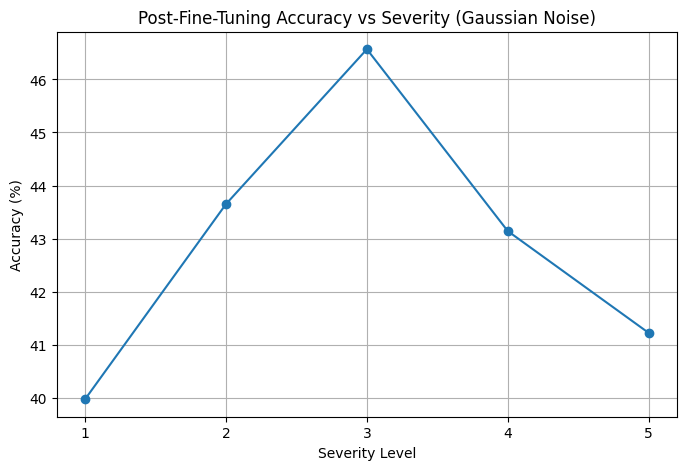

In [ ]:
# Assume model is your fine-tuned model
severities, accuracies = evaluate_across_severities(model, corruption='gaussian_noise', path='/content/gaussian')

plot_accuracy_vs_severity(severities, accuracies, title="Post-Fine-Tuning Accuracy vs Severity (Gaussian Noise)")


Because I finetuned the model for severity 3, the accuracy is highest for that.

In [ ]:
# Save entire model (recommended for quick sharing)
torch.save(model.state_dict(), 'resnet18_finetuned_gaussian_sev3.pth')

